# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


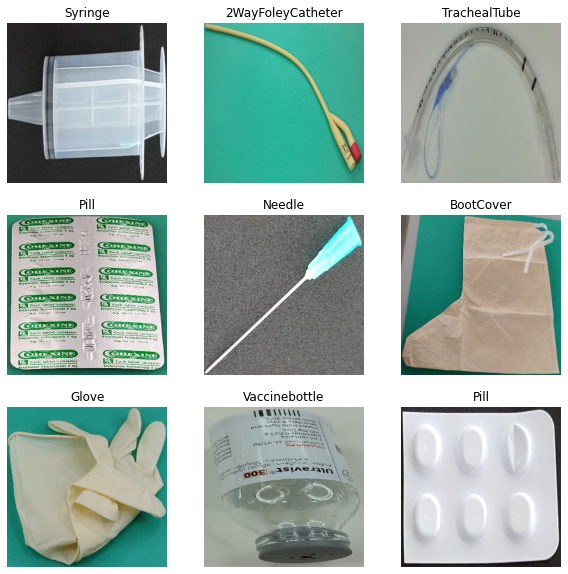

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


# Fitting

In [3]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-NormalLR/'

In [22]:
EPOCHS = 4000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/4000
49/49 [==============================] - 45s 328ms/step - loss: 1.8225 - accuracy: 0.5454 - val_loss: 0.9183 - val_accuracy: 0.7865
Epoch 2/4000
49/49 [==============================] - 8s 169ms/step - loss: 0.6395 - accuracy: 0.8572 - val_loss: 0.5495 - val_accuracy: 0.8797
Epoch 3/4000
49/49 [==============================] - 8s 170ms/step - loss: 0.3828 - accuracy: 0.9292 - val_loss: 0.4110 - val_accuracy: 0.9094
Epoch 4/4000
49/49 [==============================] - 8s 169ms/step - loss: 0.2715 - accuracy: 0.9586 - val_loss: 0.3392 - val_accuracy: 0.9133
Epoch 5/4000
49/49 [==============================] - 8s 170ms/step - loss: 0.2079 - accuracy: 0.9712 - val_loss: 0.2947 - val_accuracy: 0.9211
Epoch 6/4000
49/49 [==============================] - 8s 170ms/step - loss: 0.1664 - accuracy: 0.9796 - val_loss: 0.2633 - val_accuracy: 0.9327
Epoch 7/4000
49/49 [==============================] - 8s 169ms/step - loss: 0.1371 - accuracy: 0.9842 - val_loss: 0.2394 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

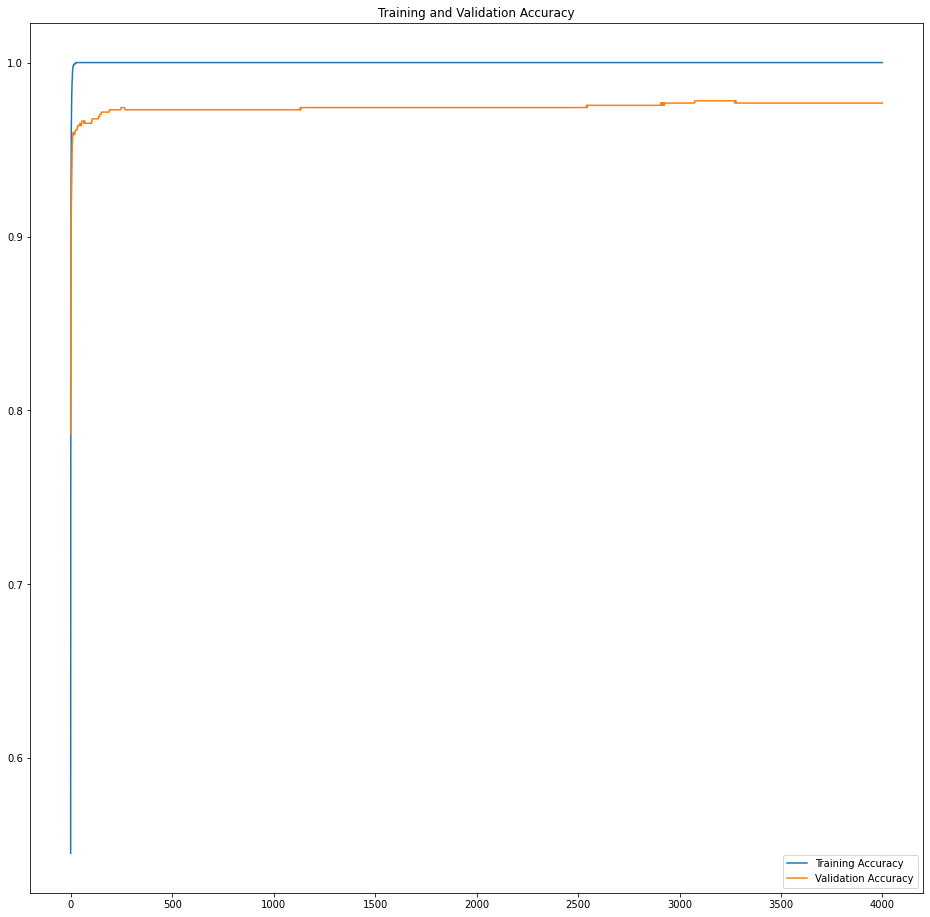

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


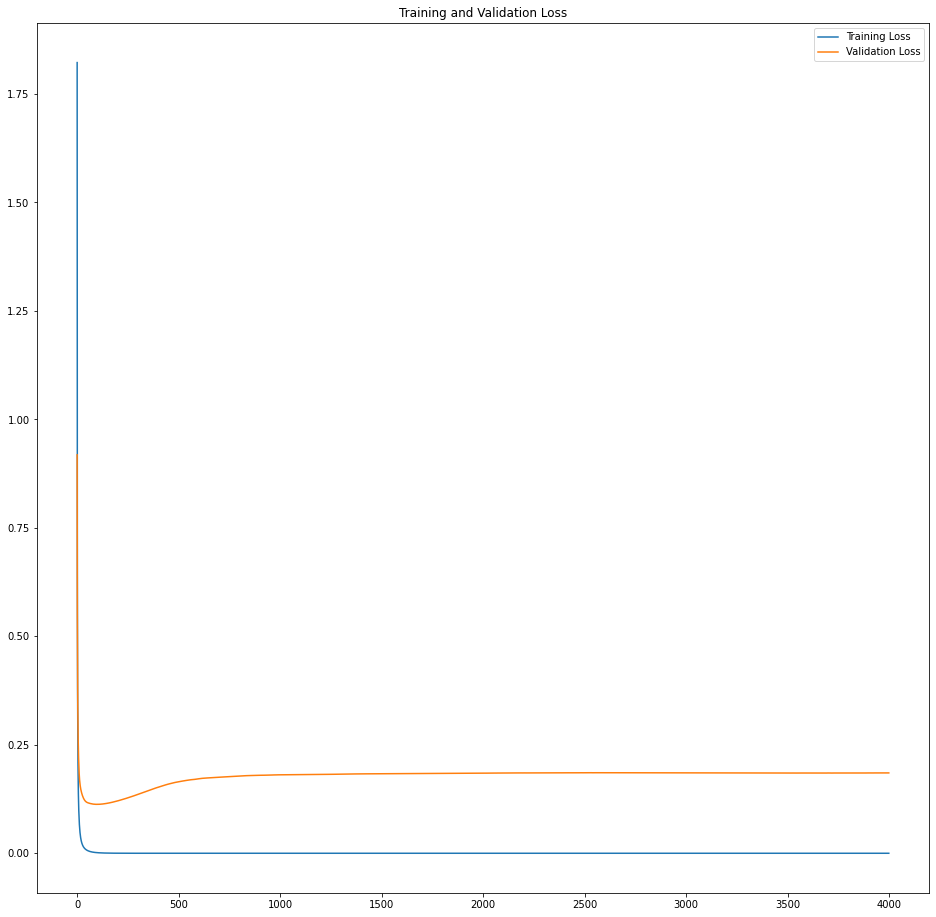

In [24]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 341ms/step - loss: 0.8018 - accuracy: 0.8512
test_indoor_ds_results:test loss, test acc: [0.8017758727073669, 0.851170539855957]


In [26]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 444ms/step - loss: 2.2489 - accuracy: 0.7268
test_outdoor_ds_results:test loss, test acc: [2.24892258644104, 0.7267515659332275]


In [27]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 203ms/step - loss: 2.2312 - accuracy: 0.7004
test_belt_ds_results:test loss, test acc: [2.231168508529663, 0.7003626227378845]


In [28]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.96.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-NormalLR/OurO

# Testing in testset

In [29]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 133ms/step - loss: 1.3801 - accuracy: 0.6646
Epoch040 
 test_indoor_acc=0.827201783657074 
 test_outdoor_acc=0.7308917045593262 
 test_belt_acc=0.6645511984825134
35/35 [==============================] - 5s 133ms/step - loss: 1.4673 - accuracy: 0.6727
Epoch080 
 test_indoor_acc=0.8394649028778076 
 test_outdoor_acc=0.7375796437263489 
 test_belt_acc=0.6727107763290405
35/35 [==============================] - 5s 134ms/step - loss: 1.5831 - accuracy: 0.6709
Epoch120 
 test_indoor_acc=0.843366801738739 
 test_outdoor_acc=0.7391719818115234 
 test_belt_acc=0.6708975434303284
35/35 [==============================] - 5s 134ms/step - loss: 1.6895 - accuracy: 0.6741
Epoch160 
 test_indoor_acc=0.845596432685852 
 test_outdoor_acc=0.7394904494285583 
 test_belt_acc=0.6740707159042358
35/35 [==============================] - 5s 134ms/step - loss: 1.7961 - accuracy: 0.6772
Epoch200 
 test_indoor_acc=0.8494983315467834 
 test_outdoor_acc=0.739171981811523

In [40]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 4040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

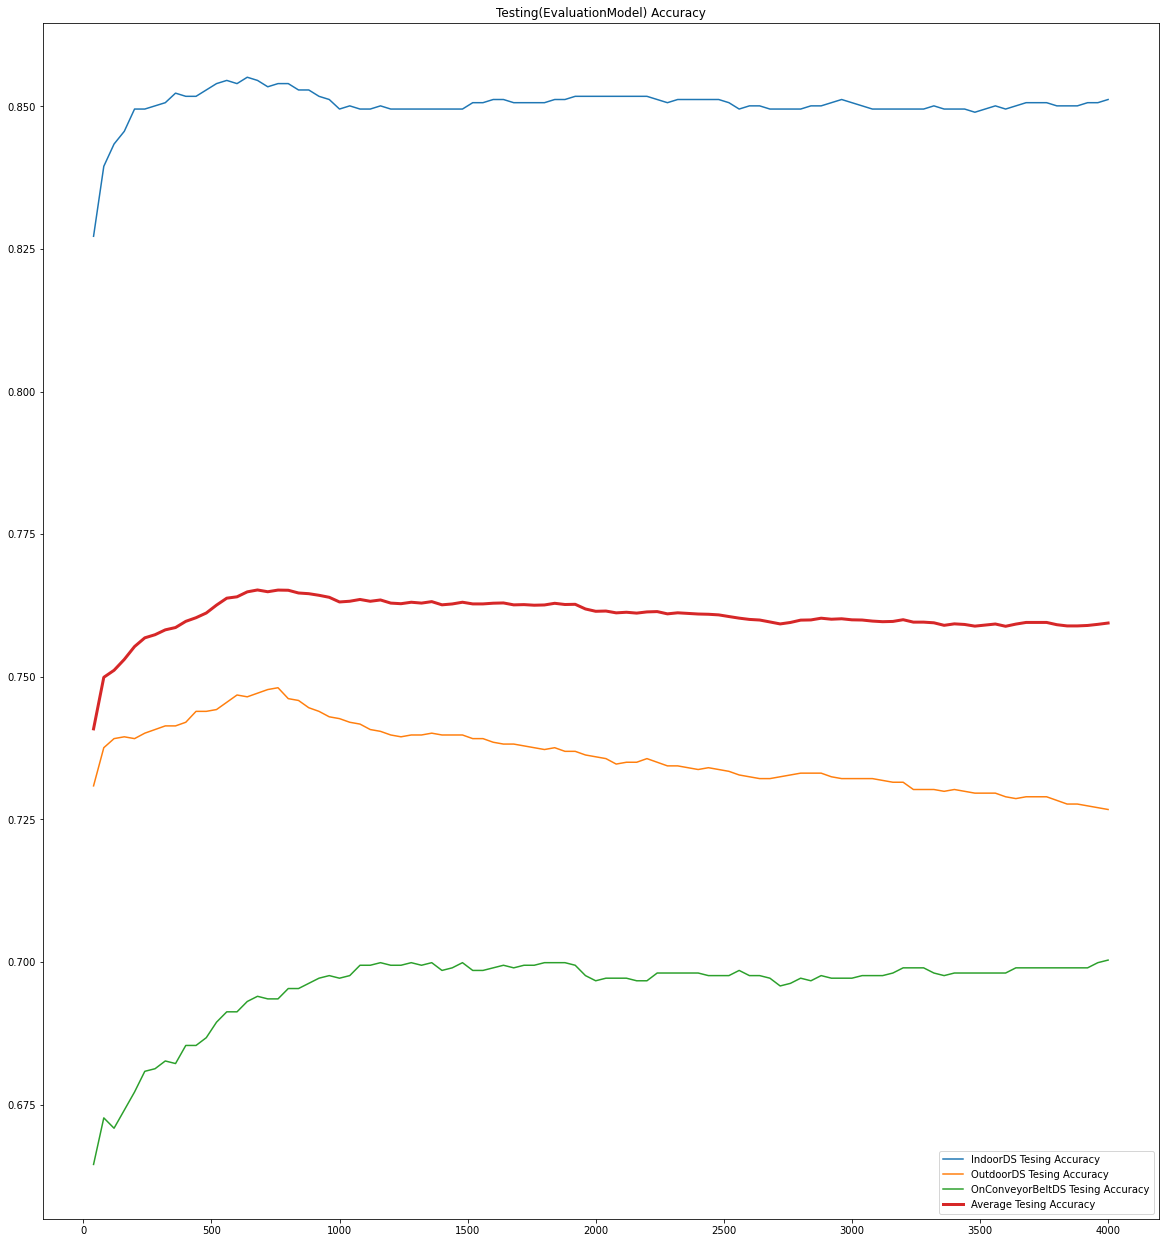

In [42]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [43]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7652217149734497
max index -> 16
The [Epoch] of max acc -> 680


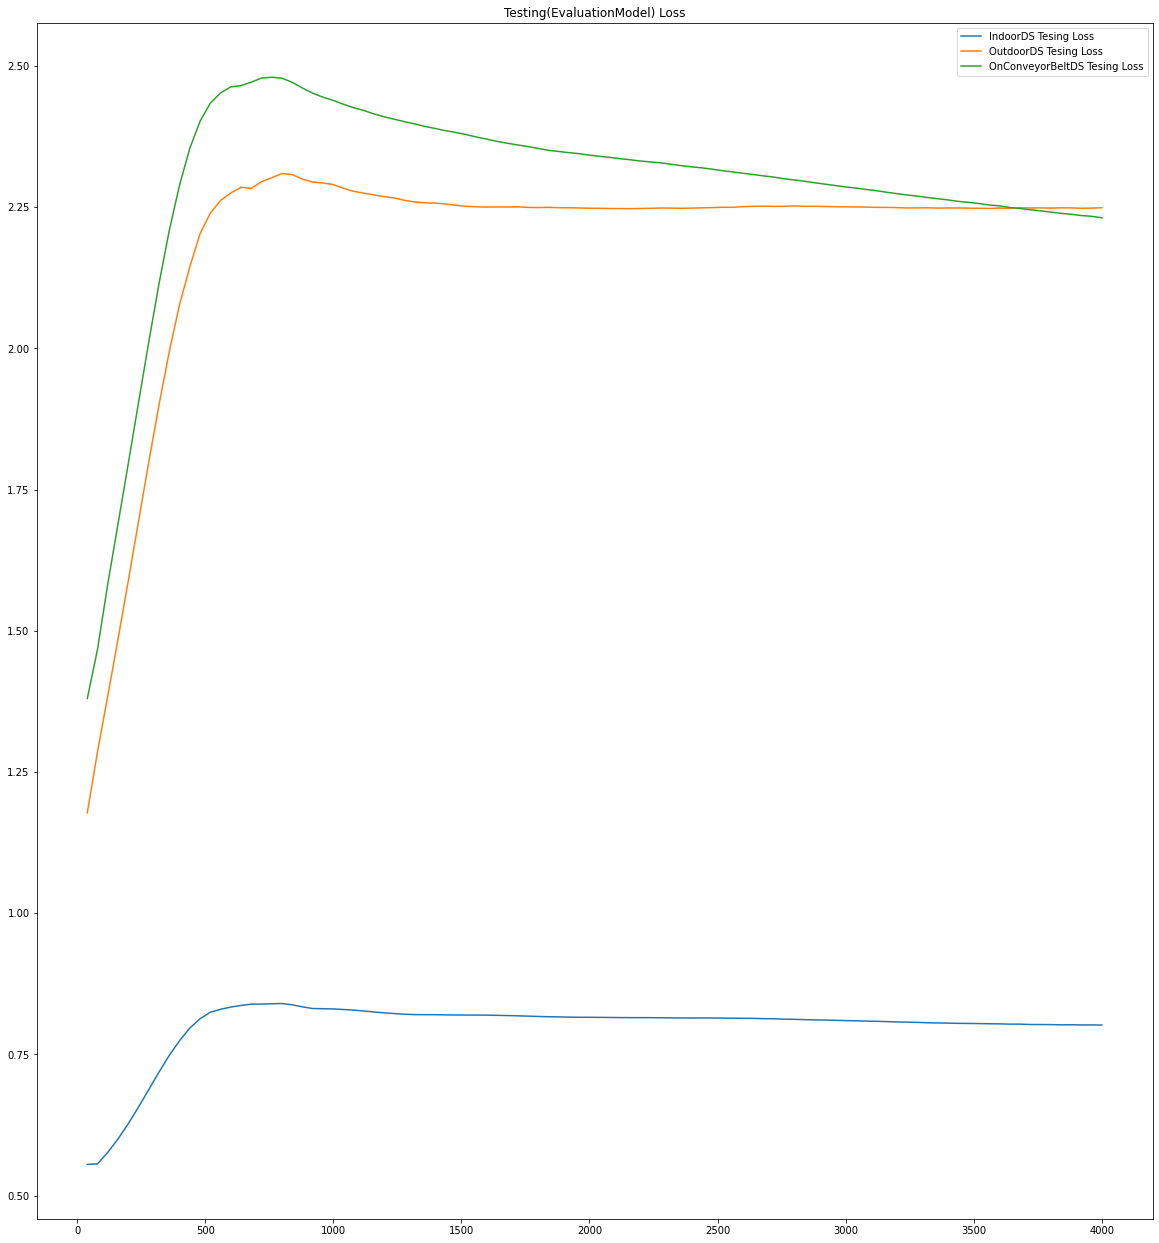

In [31]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [32]:
test_indoor_acc

[0.827201783657074,
 0.8394649028778076,
 0.843366801738739,
 0.845596432685852,
 0.8494983315467834,
 0.8494983315467834,
 0.8500557541847229,
 0.8506131768226624,
 0.8522853851318359,
 0.8517279624938965,
 0.8517279624938965,
 0.8528428077697754,
 0.8539576530456543,
 0.8545150756835938,
 0.8539576530456543,
 0.8550724387168884,
 0.8545150756835938,
 0.8534002304077148,
 0.8539576530456543,
 0.8539576530456543,
 0.8528428077697754,
 0.8528428077697754,
 0.8517279624938965,
 0.851170539855957,
 0.8494983315467834,
 0.8500557541847229,
 0.8494983315467834,
 0.8494983315467834,
 0.8500557541847229,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8506131768226624,
 0.8506131768226624,
 0.851170539855957,
 0.851170539855957,
 0.8506131768226624,
 0.8506131768226624,
 0.8506131768226624,
 0.8506131768226624,
 0.851170539855957,
 0.851170539855957,
 0.8517279624938965,


In [33]:
test_outdoor_acc

[0.7308917045593262,
 0.7375796437263489,
 0.7391719818115234,
 0.7394904494285583,
 0.7391719818115234,
 0.7401273846626282,
 0.740764319896698,
 0.7414012551307678,
 0.7414012551307678,
 0.7420381903648376,
 0.7439490556716919,
 0.7439490556716919,
 0.7442675232887268,
 0.7455413937568665,
 0.7468152642250061,
 0.7464967966079712,
 0.747133731842041,
 0.7477707266807556,
 0.7480891942977905,
 0.7461783289909363,
 0.7458598613739014,
 0.7445859909057617,
 0.7439490556716919,
 0.7429936528205872,
 0.7426751852035522,
 0.7420381903648376,
 0.7417197227478027,
 0.740764319896698,
 0.7404458522796631,
 0.7398089170455933,
 0.7394904494285583,
 0.7398089170455933,
 0.7398089170455933,
 0.7401273846626282,
 0.7398089170455933,
 0.7398089170455933,
 0.7398089170455933,
 0.7391719818115234,
 0.7391719818115234,
 0.7385350465774536,
 0.7382165789604187,
 0.7382165789604187,
 0.7378981113433838,
 0.7375796437263489,
 0.737261176109314,
 0.7375796437263489,
 0.7369426488876343,
 0.73694264888763

In [34]:
test_belt_acc

[0.6645511984825134,
 0.6727107763290405,
 0.6708975434303284,
 0.6740707159042358,
 0.6772438883781433,
 0.6808703541755676,
 0.6813236474990845,
 0.6826835870742798,
 0.6822302937507629,
 0.6854034662246704,
 0.6854034662246704,
 0.686763346195221,
 0.6894832253456116,
 0.6912964582443237,
 0.6912964582443237,
 0.6931096911430359,
 0.6940163373947144,
 0.6935629844665527,
 0.6935629844665527,
 0.6953762173652649,
 0.6953762173652649,
 0.6962828636169434,
 0.6971895098686218,
 0.6976428031921387,
 0.6971895098686218,
 0.6976428031921387,
 0.6994560360908508,
 0.6994560360908508,
 0.6999093294143677,
 0.6994560360908508,
 0.6994560360908508,
 0.6999093294143677,
 0.6994560360908508,
 0.6999093294143677,
 0.6985493898391724,
 0.699002742767334,
 0.6999093294143677,
 0.6985493898391724,
 0.6985493898391724,
 0.699002742767334,
 0.6994560360908508,
 0.699002742767334,
 0.6994560360908508,
 0.6994560360908508,
 0.6999093294143677,
 0.6999093294143677,
 0.6999093294143677,
 0.69945603609085

In [35]:
test_indoor_loss

[0.5550245642662048,
 0.5560601353645325,
 0.5765888690948486,
 0.6002238988876343,
 0.6272113919258118,
 0.6567273736000061,
 0.6876388192176819,
 0.7186765074729919,
 0.7481929063796997,
 0.7740600109100342,
 0.7964295744895935,
 0.8128857612609863,
 0.8244883418083191,
 0.8296615481376648,
 0.8336814045906067,
 0.8364964127540588,
 0.8388363718986511,
 0.839028000831604,
 0.8394985795021057,
 0.839870810508728,
 0.8376498818397522,
 0.8340349197387695,
 0.831097424030304,
 0.830730140209198,
 0.830387532711029,
 0.8293417096138,
 0.8282836079597473,
 0.8267495632171631,
 0.8248436450958252,
 0.8234074711799622,
 0.8221268653869629,
 0.8209714293479919,
 0.8202856183052063,
 0.820184588432312,
 0.8201675415039062,
 0.8198180794715881,
 0.8196463584899902,
 0.8195286393165588,
 0.81951904296875,
 0.8193851113319397,
 0.8189942836761475,
 0.8186449408531189,
 0.8181676864624023,
 0.8176275491714478,
 0.8170246481895447,
 0.8165400624275208,
 0.816252589225769,
 0.8158548474311829,
 0.8

In [36]:
test_outdoor_loss

[1.1775892972946167,
 1.2863689661026,
 1.3848931789398193,
 1.485408067703247,
 1.588600993156433,
 1.6937974691390991,
 1.798785924911499,
 1.9001586437225342,
 1.9944487810134888,
 2.0773427486419678,
 2.144101619720459,
 2.2029404640197754,
 2.239187479019165,
 2.261779546737671,
 2.275069236755371,
 2.285158157348633,
 2.283160448074341,
 2.295161008834839,
 2.302028179168701,
 2.309647560119629,
 2.307615280151367,
 2.299469232559204,
 2.2945187091827393,
 2.2927565574645996,
 2.2899258136749268,
 2.2833518981933594,
 2.2779042720794678,
 2.2747855186462402,
 2.271559953689575,
 2.268500804901123,
 2.2660791873931885,
 2.261826992034912,
 2.259119749069214,
 2.2575535774230957,
 2.2570884227752686,
 2.2554447650909424,
 2.253300666809082,
 2.2513246536254883,
 2.2506325244903564,
 2.250053882598877,
 2.250317335128784,
 2.2502079010009766,
 2.250458002090454,
 2.249572515487671,
 2.2491836547851562,
 2.2496702671051025,
 2.248955249786377,
 2.2489728927612305,
 2.248526096343994,

In [37]:
test_belt_loss

[1.3800737857818604,
 1.467330813407898,
 1.5831201076507568,
 1.6894938945770264,
 1.7960954904556274,
 1.904093861579895,
 2.011464834213257,
 2.1148219108581543,
 2.208714485168457,
 2.288938522338867,
 2.3541500568389893,
 2.401968479156494,
 2.434047222137451,
 2.4522006511688232,
 2.462895154953003,
 2.4651787281036377,
 2.471236228942871,
 2.478579044342041,
 2.479997396469116,
 2.4783787727355957,
 2.4709150791168213,
 2.460876703262329,
 2.4517133235931396,
 2.4446587562561035,
 2.4390246868133545,
 2.4321401119232178,
 2.425955057144165,
 2.420997142791748,
 2.4149482250213623,
 2.409869432449341,
 2.405427932739258,
 2.401186943054199,
 2.397188663482666,
 2.3926851749420166,
 2.3891072273254395,
 2.38519287109375,
 2.382129430770874,
 2.378281831741333,
 2.374054431915283,
 2.3703112602233887,
 2.3663060665130615,
 2.3630776405334473,
 2.3600680828094482,
 2.357252836227417,
 2.353935718536377,
 2.350580930709839,
 2.3485772609710693,
 2.3464536666870117,
 2.344662427902221

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch0680-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [13]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5410
FP=1730
acc=0.757703081232493
all check = 7140


In [14]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 78.44827586206897%
2WayConnectorforFoley acc = 90.47619047619048%
2WayFoleyCatheter acc = 74.6268656716418%
3WayConnectorforFoley acc = 95.72649572649573%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 87.5%
AlcoholPad acc = 51.587301587301596%
BootCover acc = 65.66265060240963%
CottonBall acc = 77.84431137724552%
CottonSwap acc = 79.02097902097903%
Dilator acc = 72.64957264957265%
DisposableInfusionSet acc = 55.75221238938053%
ExtensionTube acc = 39.83739837398374%
FaceShield acc = 72.22222222222221%
FrontLoadSyringe acc = 53.98230088495575%
GauzePad acc = 59.65909090909091%
Glove acc = 75.89285714285714%
GuideWire acc = 35.714285714285715%
LiquidBottle acc = 60.68702290076335%
Mask acc = 94.02597402597402%
NGTube acc = 43.87096774193549%
NasalCannula acc = 69.02654867256636%
Needle acc = 84.28571428571429%
OxygenMask acc = 97.74436090225564%
PPESuit acc = 95.16129032258065%
PharmaceuticalProduct acc = 63.084112149532714%
Pill acc = 95.2380952380

In [7]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 93,   0,   0, ...,   0,   2,   0],
       [  0, 131,   0, ...,   0,   0,   0],
       [  0,   0, 100, ...,   0,   1,   4],
       ...,
       [  0,   0,   0, ...,  68,   0,   0],
       [  0,   0,   0, ...,   1, 182,   0],
       [  0,   1,   0, ...,   1,   1,  76]], dtype=int64)

In [8]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[80.17241379,  0.        ,  0.        , ...,  0.        ,
         1.72413793,  0.        ],
       [ 0.        , 89.11564626,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 74.62686567, ...,  0.        ,
         0.74626866,  2.98507463],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 56.66666667,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        85.44600939,  0.        ],
       [ 0.        ,  0.87719298,  0.        , ...,  0.87719298,
         0.87719298, 66.66666667]])

<AxesSubplot:>

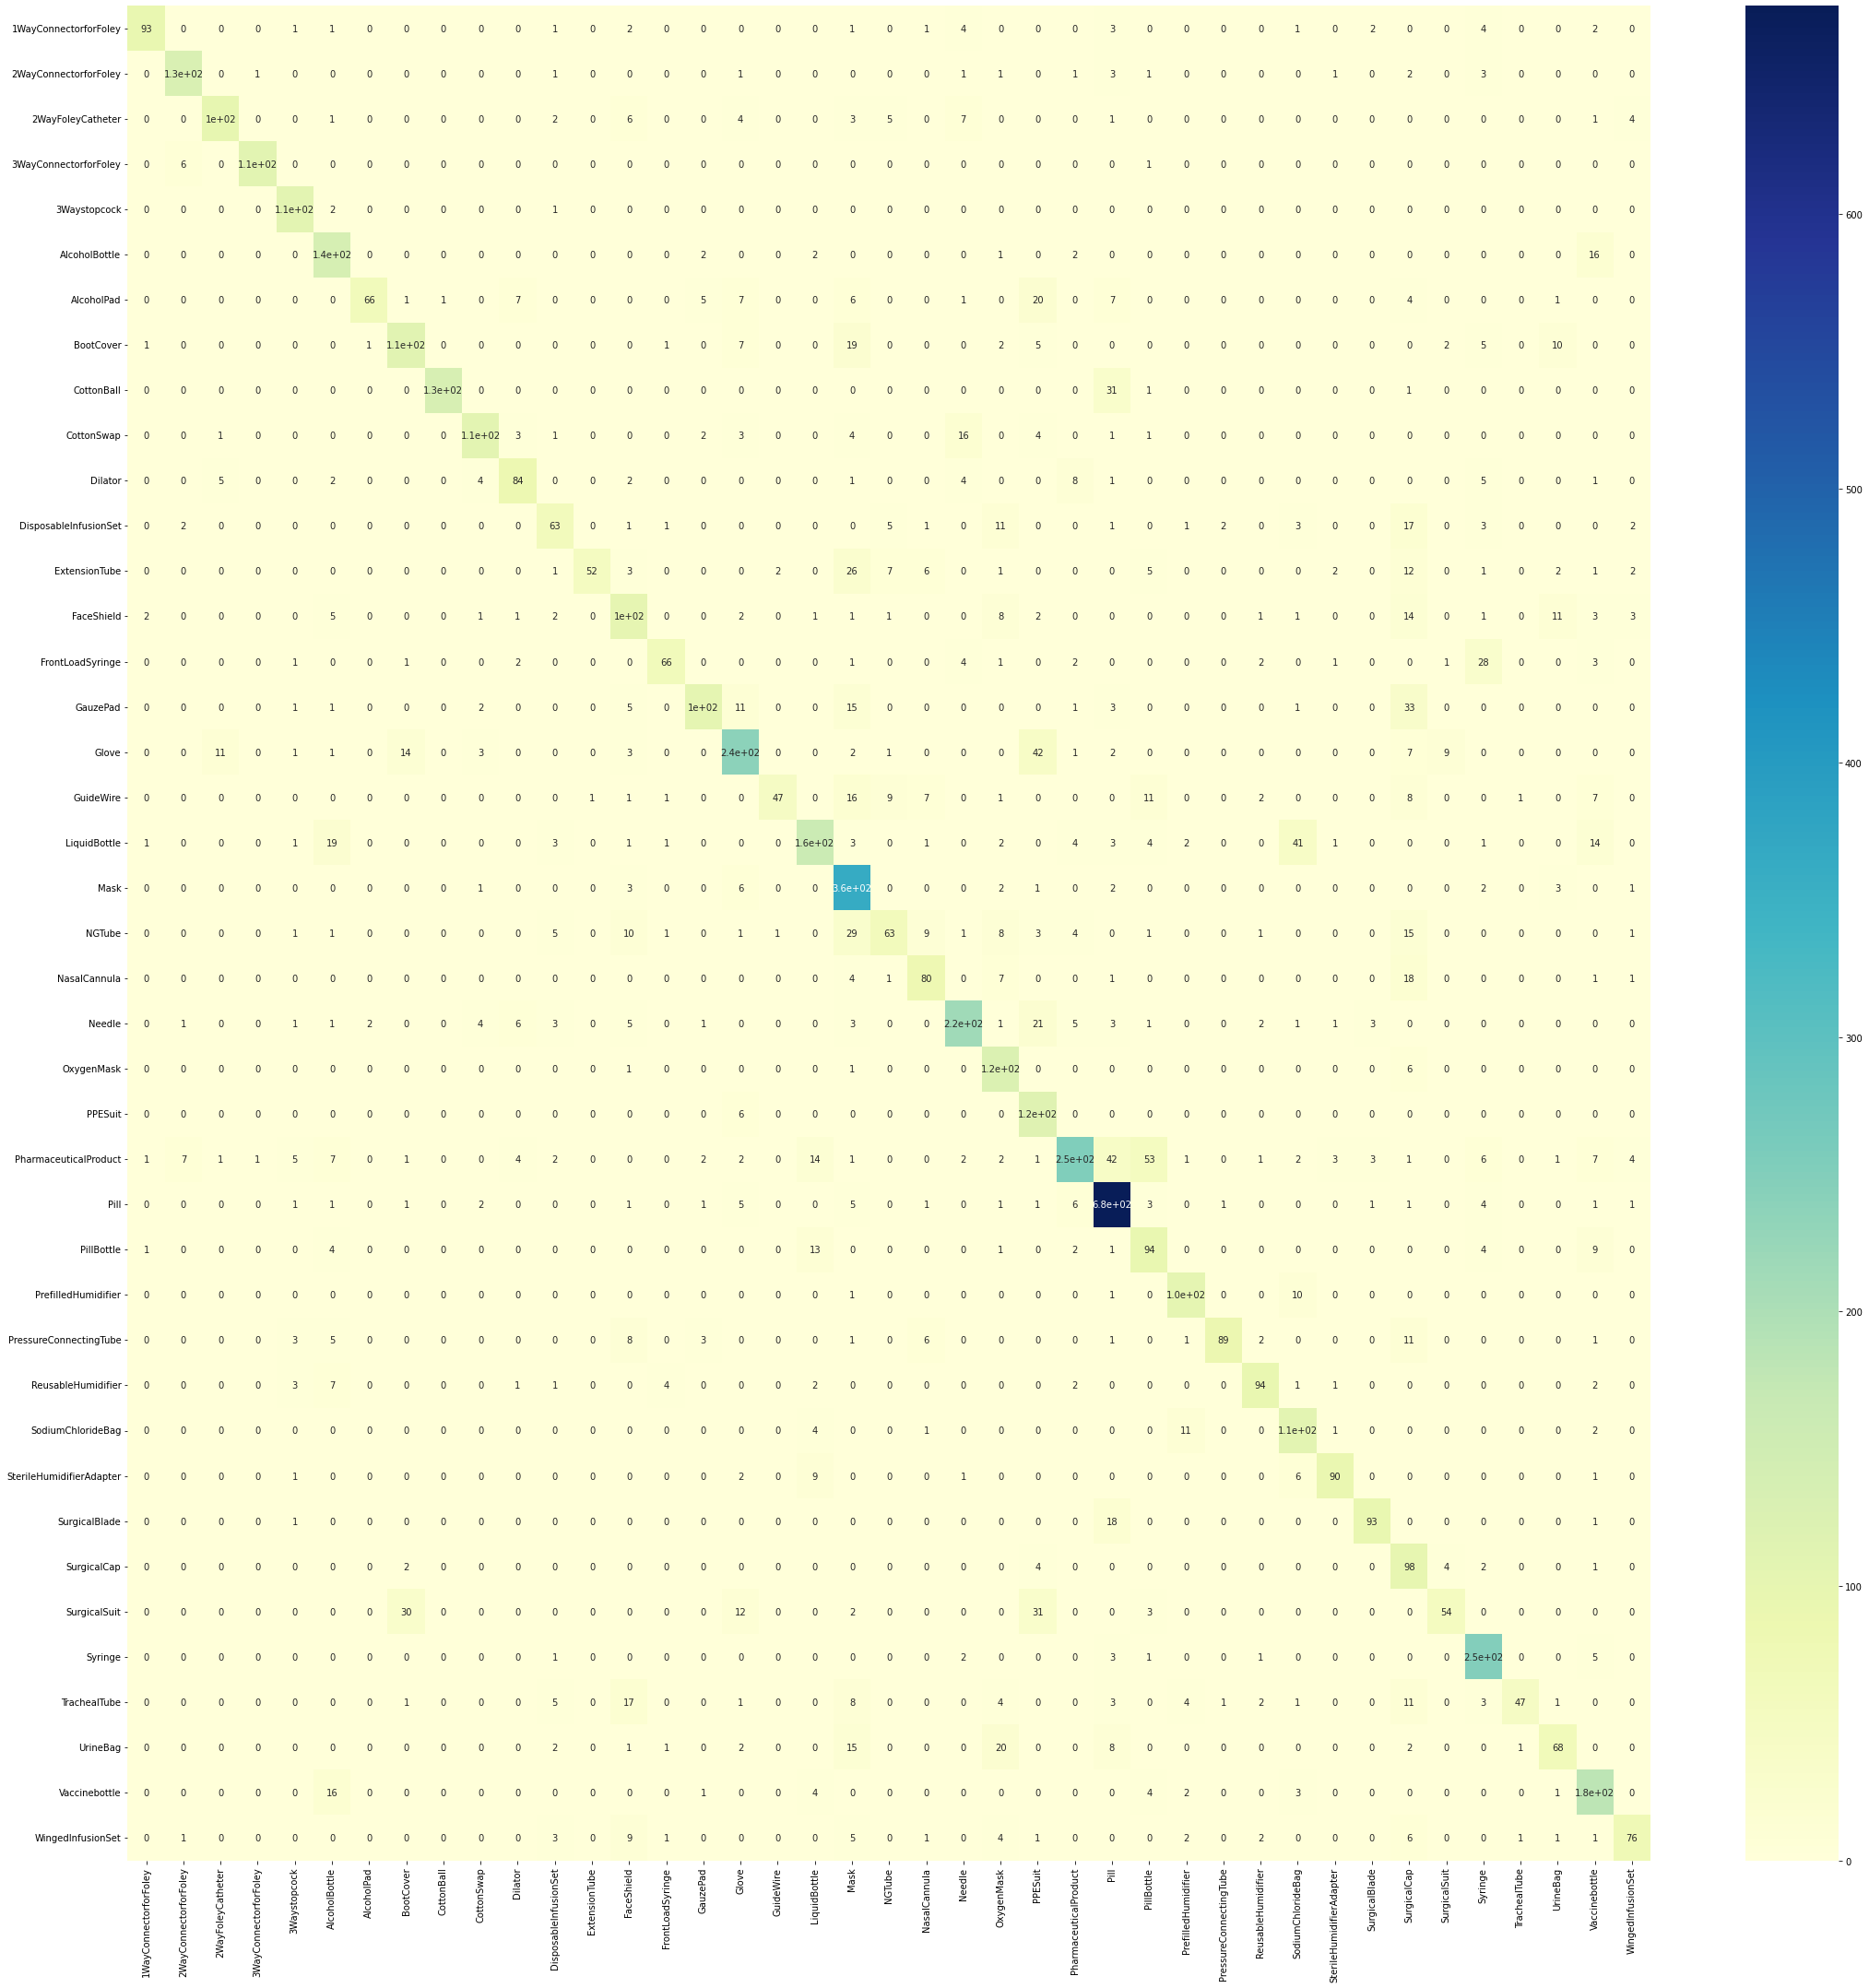

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

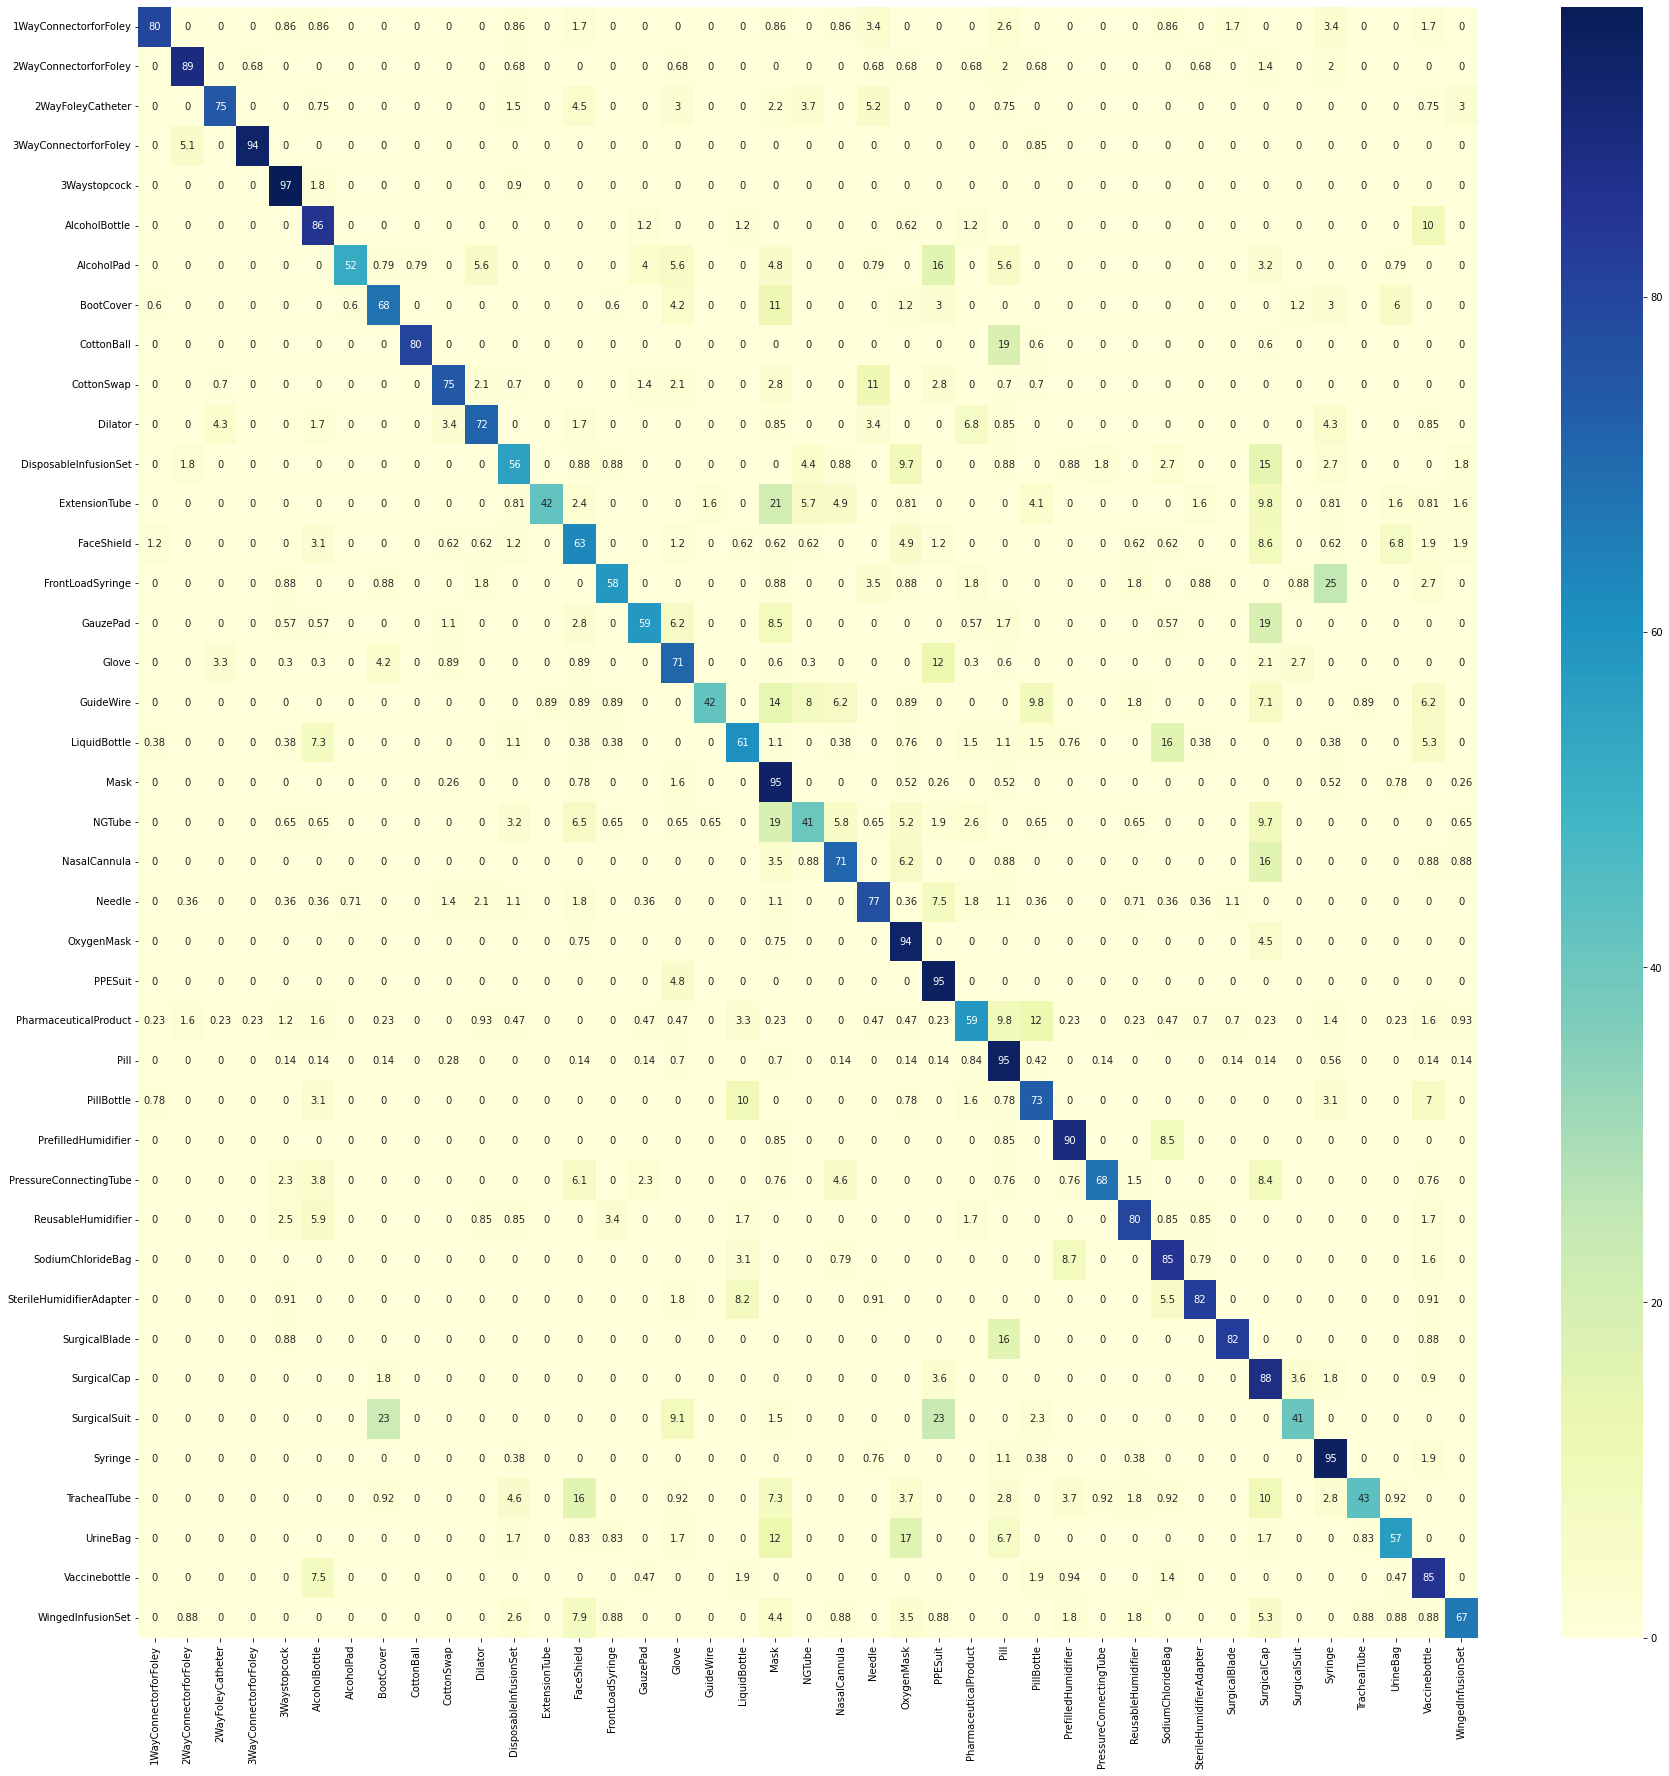

In [10]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")